In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('pySparkSetup').getOrCreate()

24/05/28 17:08:58 WARN Utils: Your hostname, Ugurs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.101 instead (on interface en0)
24/05/28 17:08:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/28 17:08:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
weather = spark.read.parquet("/Users/ugurkalkavan/Downloads/m06sparkbasics/weather")

In [4]:
import math


def predict_num_partitions(files):
    ## What is the maximum size of each spark-partition (default value)?
    defaultMaxPartitionBytes = int(spark.conf.get("spark.sql.files.maxPartitionBytes").replace("b",""))

    ## What is the cost in bytes for each file (default value)?
    open_cost_bytes = int(spark.conf.get("spark.sql.files.openCostInBytes").replace("b",""))
    
    max_partition_bytes = int(spark.conf.get("spark.sql.files.maxPartitionBytes").replace("b",""))

    
    #actual_bytes = sum([file.size for file in files])               # Total size of the dataset on disk 
    actual_bytes = sum([os.path.getsize(file_path) for file_path in files])
    padded_bytes = actual_bytes + (len(files) * open_cost_bytes)          # Final size with padding from openCost

    bytes_per_core = (padded_bytes/spark.sparkContext.defaultParallelism)           # The number of bytes per core
    max_of_cost_BPC = max(open_cost_bytes, bytes_per_core)                # Larger of openCost and bytesPerCore
    target_size = min(max_partition_bytes , max_of_cost_BPC)        # Smaller of maxPartitionBytes and maxOfCostBPC
    partitions = padded_bytes /  float(target_size)                 # The final number of partitions (needs to be rounded up)



    print("defaultMaxPartitionBytes:", defaultMaxPartitionBytes)
    print("")
    print("---")
    print("File Count:", len(files))
    print("Actual Bytes:", actual_bytes)
    print("Padded Bytes:", padded_bytes, "Actual_Bytes + (File_Count * Open_Cost)")
    print("Average Size:", (padded_bytes/len(files)))
    print("---")
    print("Open Cost:", open_cost_bytes, "spark.sql.files.openCostInBytes")
    print("Bytes-Per-Core:", bytes_per_core, "padded_bytes / Default Parallelism")
    print("Max Cost:", max_of_cost_BPC, "(max of Open_Cost & Bytes-Per-Core)")
    print("---")
    print("Max Partition Bytes:", max_partition_bytes, "spark.sql.files.maxPartitionBytes")
    print("Target Size:", target_size, "(min of Max_Cost & Max_Partition_Bytes)")
    print("---")
    print("Number of Partions:", math.ceil(partitions), f"({partitions} from Padded_Bytes / Target_Size)")


In [5]:
## Source directory for this experiment's dataset
trxPath = "/Users/ugurkalkavan/Downloads/m06sparkbasics/weather" 

## All the parquet files in this dataset
## trxFiles = dbutils.fs.ls(trxPath).filter(_.name.endsWith(".parquet"))

import os

trx_files = []
for dirpath, dirs, files in os.walk(trxPath):
    for filename in files:
        if filename.endswith(".parquet"):
            trx_files.append(os.path.join(dirpath, filename))




## COMMAND ----------

#spark.setJobDescription("Step C: Read at 1x")



#maxPartitionBytesConf = f"{defaultMaxPartitionBytes * 1}"
#spark.conf.set("spark.sql.files.maxPartitionBytes", maxPartitionBytesConf)



predict_num_partitions(trx_files)


spark.read.parquet(trxPath).write.format("noop").mode("overwrite").save() ## Test with a noop write


defaultMaxPartitionBytes: 134217728

---
File Count: 276
Actual Bytes: 934260584
Padded Bytes: 2091888488 Actual_Bytes + (File_Count * Open_Cost)
Average Size: 7579306.115942029
---
Open Cost: 4194304 spark.sql.files.openCostInBytes
Bytes-Per-Core: 209188848.8 padded_bytes / Default Parallelism
Max Cost: 209188848.8 (max of Open_Cost & Bytes-Per-Core)
---
Max Partition Bytes: 134217728 spark.sql.files.maxPartitionBytes
Target Size: 134217728 (min of Max_Cost & Max_Partition_Bytes)
---
Number of Partions: 16 (15.585783779621124 from Padded_Bytes / Target_Size)


In [6]:
spark

In [7]:
weather.rdd.getNumPartitions()

16

In [8]:
# Number of partitions
num_partitions = weather.rdd.getNumPartitions()

# Size of each partition in MB
partition_sizes = weather.rdd.mapPartitions(lambda x: [sys.getsizeof(x)]).collect()


# Convert Bytes to MB
partition_sizes_MB = [i/1048576 for i in partition_sizes]

# Number of rows in each partition
rows_per_partition = weather.rdd.mapPartitions(lambda x: [sum(1 for _ in x)]).collect()

for i in range(num_partitions):
    print(i)
    print("Partition {0} size: {1} MB".format(i, partition_sizes_MB[i]))
    print("Partition {0} number of rows: {1}".format(i, rows_per_partition[i]))
    print("---------------------------------------")

0
Partition 0 size: 4.57763671875e-05 MB
Partition 0 number of rows: 6049095
---------------------------------------
1
Partition 1 size: 4.57763671875e-05 MB
Partition 1 number of rows: 6048640
---------------------------------------
2
Partition 2 size: 4.57763671875e-05 MB
Partition 2 number of rows: 6048380
---------------------------------------
3
Partition 3 size: 4.57763671875e-05 MB
Partition 3 number of rows: 6048380
---------------------------------------
4
Partition 4 size: 4.57763671875e-05 MB
Partition 4 number of rows: 6048536
---------------------------------------
5
Partition 5 size: 4.57763671875e-05 MB
Partition 5 number of rows: 6048887
---------------------------------------
6
Partition 6 size: 4.57763671875e-05 MB
Partition 6 number of rows: 6048887
---------------------------------------
7
Partition 7 size: 4.57763671875e-05 MB
Partition 7 number of rows: 4690772
---------------------------------------
8
Partition 8 size: 4.57763671875e-05 MB
Partition 8 number of r

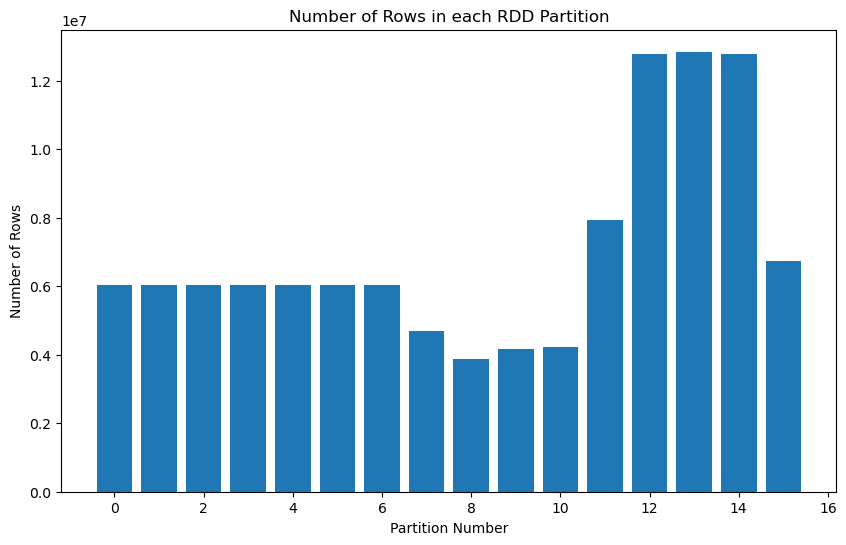

In [9]:
import matplotlib.pyplot as plt
# Visualizing the data
plt.figure(figsize=(10, 6)) 
plt.bar(range(len(rows_per_partition)), rows_per_partition)

plt.xlabel('Partition Number')
plt.ylabel('Number of Rows')
plt.title('Number of Rows in each RDD Partition')
plt.show()

In [10]:
weather = weather.repartition(15)

In [11]:
weather.rdd.getNumPartitions()

24/05/28 17:10:21 ERROR Executor: Exception in task 5.0 in stage 5.0 (TID 55)16]
java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:50)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.getSortedIterator(UnsafeExternalSorter.java:555)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:172)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:228)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.$anonfun$prepareShuffleDependency$10(ShuffleExchangeExec.scala:375)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$$Lambda$3282/749959920.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.ap

ConnectionRefusedError: [Errno 61] Connection refused

In [ ]:
# Number of partitions
num_partitions = weather.rdd.getNumPartitions()

# Size of each partition in MB
partition_sizes = weather.rdd.mapPartitions(lambda x: [sys.getsizeof(x)]).collect()


# Convert Bytes to MB
partition_sizes_MB = [i/1048576 for i in partition_sizes]

# Number of rows in each partition
rows_per_partition = weather.rdd.mapPartitions(lambda x: [sum(1 for _ in x)]).collect()

for i in range(num_partitions):
    print(i)
    print("Partition {0} size: {1} MB".format(i, partition_sizes_MB[i]))
    print("Partition {0} number of rows: {1}".format(i, rows_per_partition[i]))
    print("---------------------------------------")

In [ ]:
import matplotlib.pyplot as plt
# Visualizing the data
plt.figure(figsize=(10, 6)) 
plt.bar(range(len(rows_per_partition)), rows_per_partition)

plt.xlabel('Partition Number')
plt.ylabel('Number of Rows')
plt.title('Number of Rows in each RDD Partition')
plt.show()